In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()
train_imgs = train_imgs.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
test_imgs = test_imgs.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
train_lbls = train_lbls.astype(np.int32)[:,0]
test_lbls = test_lbls.astype(np.int32)[:,0]

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls))
train_data = train_data.shuffle(60000).batch(256).repeat()

test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls)).batch(256)

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
# build model
tfkl = tf.keras.layers


regularization_factor = 0.00001


def conv_bn_relu(inp, n_filters):
    # use regularizers for weight penalties etc
    # note that the factor needs to be passed here already
    conv = tfkl.Conv2D(n_filters, 3, padding="same", use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(inp)
    # batchnorm is as simple as this.
    # note: convolution has set use_bias=False since it's superfluous if followed
    # by batchnorm directly
    bn = tfkl.BatchNormalization()(conv)
    # spatial dropout is probably a better choice for conv2d
    # NOTE dropout & batch norm don't harmonize well, so probably better to
    # choose one of the two
    return tfkl.SpatialDropout2D(0.2)(tfkl.ReLU()(bn))

def build_model():
    inp = tf.keras.Input((32, 32, 3))

    # best way to do data augmentation: use keras layers
    flipped = tfkl.RandomFlip(mode="horizontal")(inp)
    cropped = tfkl.RandomCrop(30, 30)(flipped)

    l1 = conv_bn_relu(cropped, 32)
    #l1b = conv_bn_relu(l1, 32)
    l1_p = tfkl.MaxPool2D(2, padding="same")(l1)

    l2 = conv_bn_relu(l1_p, 64)
    #l2b = conv_bn_relu(l2, 64)
    l2_p = tfkl.MaxPool2D(2, padding="same")(l2)

    l3 = conv_bn_relu(l2_p, 128)
    #l3b = conv_bn_relu(l3, 128)
    l3_p = tfkl.MaxPool2D(2, padding="same")(l3)

    flat = tfkl.Flatten()(l3_p)
    logits = tfkl.Dense(10, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(flat)

    model = tf.keras.Model(inp, logits)
    return model


model = build_model()
train_steps = 10000

# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay( 0.001, 1, 0.9997)   #(initial_learning_rate, decay_steps, decay_rate)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


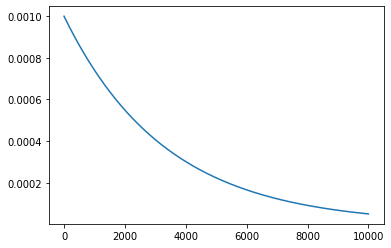

In [ ]:
x = tf.range(train_steps)
y = schedule(x)
plt.plot(x, y)

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # very important to have training=True!!!
        # in this model, this is relevant for dropout, batchnorm, augmentation
        out = model(images, training=True)
        cross_entropy = loss_fn(labels, out)

        # we actually need to add the regularization here!
        # using model.fit, this would be taken care off
        l2_penalty = tf.add_n(model.losses) #add all the input tensors elementwise
        loss = cross_entropy + l2_penalty

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return cross_entropy


def get_test_accuracy():
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    for images, labels in test_data:
        # not training -> set to False. this is also the default if you don't pass it
        accuracy_metric(labels, model(images, training=False))

    return accuracy_metric.result().numpy()

In [ ]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    current_loss = train_step(image_batch, label_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()


0 3.4294872
Test acc 0.1001

500 1.2613888
Test acc 0.4586

1000 1.0235244
Test acc 0.619

1500 1.0534297
Test acc 0.6828

2000 1.0007812
Test acc 0.709

2500 0.89663965
Test acc 0.7136

3000 0.77339673
Test acc 0.7323

3500 0.8092934
Test acc 0.7281

4000 0.85296005
Test acc 0.7359

4500 0.7657181
Test acc 0.7471

5000 0.7940098
Test acc 0.7561

5500 0.7545935
Test acc 0.7516

6000 0.7326568
Test acc 0.7565

6500 0.8192864
Test acc 0.7636

7000 0.85310304
Test acc 0.7591

7500 0.78507483
Test acc 0.762

8000 0.6534521
Test acc 0.7679

8500 0.751246
Test acc 0.7644

9000 0.68544394
Test acc 0.7652

9500 0.72462213
Test acc 0.7698

10000 0.6769184
Test acc 0.7709



In [ ]:
# basic adversarial example setup
# compute gradient of loss with respect to inputs
def run_model(images, labels):
    with tf.GradientTape() as tape:
        tape.watch(images)
        out = model(images, training=False)
        cross_entropy = loss_fn(labels, out)
    gradients = tape.gradient(cross_entropy, images)
    return gradients, cross_entropy, out

In [ ]:
gradient_images, loss, predictions = run_model(image_batch, label_batch)
print("Loss on inputs:", loss.numpy())
print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
print("Correct label:", label_batch[0].numpy())
# for step, (image_batch, label_batch) in enumerate(test_data):
#     if step > 0:
#         break
#     gradient_images, loss, predictions = run_model(image_batch, label_batch)
#     print("Loss on inputs:", loss.numpy())
#     print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
#     print("Correct label:", label_batch[0].numpy())
#     adversarial_images1 = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

# gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
# but if it's too large, it doesn't really qualify as an adversarial example anymore!
# clip to between 0 and 1 since adding the gradient might take the images out of that range.
adversarial_images = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

Loss on inputs: 0.6346601
Prediction on 1st input: 3
Correct label: 4


In [ ]:
_, loss, predictions = run_model(adversarial_images, label_batch)
print("Loss on adversarial examples:", loss.numpy())
print("Prediction on 1st adversarial input:", np.argmax(predictions[0].numpy()))
print("Groundtruth:", label_batch[0].numpy())

Loss on adversarial examples: 4.640956
Prediction on 1st adversarial input: 3
Groundtruth: 4


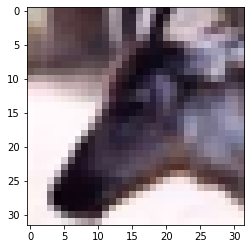

In [ ]:
plt.imshow(image_batch[0])

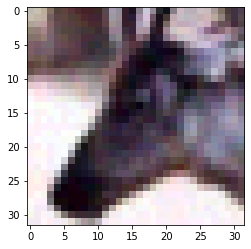

In [ ]:
plt.imshow(adversarial_images[0])

Creating adversarial dataset 

In [ ]:
# basic adversarial example setup
# compute gradient of loss with respect to inputs
def create_adversarial(images, labels):
    with tf.GradientTape() as tape:
        tape.watch(images)
        out = model(images, training=False)
        cross_entropy = loss_fn(labels, out)
    gradients = tape.gradient(cross_entropy, images)
    return gradients, cross_entropy, out


###########################################################################

model = build_model()

# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay( 0.001, 1, 0.9997)   #(initial_learning_rate, decay_steps, decay_rate)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_imgs_adv = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls)).shuffle(50000).batch(256)

# gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
# but if it's too large, it doesn't really qualify as an adversarial example anymore!
# clip to between 0 and 1 since adding the gradient might take the images out of that range.
adversarial_images = 0
adversarial_label = 0
for step, (image_batch, label_batch) in enumerate(train_imgs_adv):
    gradient_images, current_loss, predictions = create_adversarial(image_batch, label_batch)

    if step==0:
      adversarial_images = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)
      adversarial_label = label_batch
    else:
      adversarial_images = tf.concat([adversarial_images,tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)],axis=0)
      adversarial_label = tf.concat([adversarial_label, label_batch],axis=0)

    if not step % 50:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()
    



0 2.3024607
Test acc 0.0996

50 2.3035033
Test acc 0.0996

100 2.3039215
Test acc 0.0996

150 2.3142605
Test acc 0.0996



Training with adversarial + original dataset

In [ ]:
train_data2 = tf.data.Dataset.from_tensor_slices((tf.concat([adversarial_images[:25000],train_imgs[:25000]],axis=0),
                                               tf.concat([adversarial_label[:25000],train_lbls[:25000]],axis=0))).shuffle(50000).batch(256).repeat()

model = build_model()
# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay( 0.001, 1, 0.9997)   #(initial_learning_rate, decay_steps, decay_rate)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_steps = 20000

for step, (image_batch, label_batch) in enumerate(train_data2):
    if step > train_steps:
        break

    current_loss = train_step(image_batch, label_batch)

    if not step % 1500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()


0 3.3696094
Test acc 0.1076

1500 0.9016641
Test acc 0.6894

3000 0.8223712
Test acc 0.7285

4500 0.7458877
Test acc 0.7279

6000 0.7339931
Test acc 0.7448

7500 0.62960505
Test acc 0.755

9000 0.7219118
Test acc 0.7577

10500 0.7108159
Test acc 0.7638

12000 0.64930284
Test acc 0.7601

13500 0.6289618
Test acc 0.7603

15000 0.61410075
Test acc 0.7623

16500 0.61399454
Test acc 0.7627

18000 0.6332916
Test acc 0.7641

19500 0.64858437
Test acc 0.7623



Test adversarial data on newly trained model

In [ ]:
for step, (image_batch, label_batch) in enumerate(test_data):
    if step > 0:
        break
    gradient_images, loss, predictions = run_model(image_batch, label_batch)
    print("Loss on inputs:", loss.numpy())
    print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
    print("Correct label:", label_batch[0].numpy())
    adversarial_images_new = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

Loss on inputs: 0.73822
Prediction on 1st input: 3
Correct label: 3


In [ ]:
_, loss, predictions = run_model(image_batch, label_batch)
print("Loss on adversarial examples:", loss.numpy())
print("Prediction on 1st adversarial input:", np.argmax(predictions[0].numpy()))
print("Groundtruth:", label_batch[0].numpy())
print()
print("Prediction on 1st adversarial input:", np.argmax(predictions[1].numpy()))
print("Groundtruth:", label_batch[1].numpy())

Loss on adversarial examples: 0.6148692
Prediction on 1st adversarial input: 3
Groundtruth: 3

Prediction on 1st adversarial input: 0
Groundtruth: 0
